This notebook helps view Hi-C files in the .cool format. 

It is based on cooler_api.ipynb on the open2c github: 

https://github.com/open2c/cooler-binder/blob/master/cooler_api.ipynb

In [1]:
import os.path as op
import matplotlib.pyplot as plt
import numpy as np
import pandas
import h5py
import matplotlib as mpl
import ipywidgets as widgets
import math

import cooler

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# activate inline plotting
%matplotlib inline

# 50kb PnM

### Load 50kb PnM Hi-C Map

In [3]:
#50000 selects 50kb resolution.
filepath_50kb = '/Users/douglas/Documents/Features_Transfer/store_Hi-C/JJ10_11_17_18.wo3kbCisTransHom.50000.cool'
c_50kb = cooler.Cooler(filepath_50kb)

### Tables About 50kb PnM Hi-C Map

In [4]:
# 057 = maternal
# 439 = paternal
# length units are base pairs
df_50_kb = c_50kb.chroms()[:] #df_50_kb stands for (pandas) data frame
total_length_bp = df_50_kb['length'].sum()#Total number of base pairs in the PnM Hi-C map
total_bins = c_50kb.extent(df_50_kb['name'].iloc[-1])[-1] #Total number of bins in the PnM Hi-C map.
print('Total base pairs in Hi-C map: ',total_length_bp)
print('Total bins in Hi-C map:       ',total_bins)
print('Total base pairs/total bins:  ', total_length_bp/total_bins)
print('')
print('057 = maternal; 439 = paternal')
print('')
print(df_50_kb)

print('')
for name in c_50kb.chromnames:
    print(name,'   ', c_50kb.extent(name))
    
#name    (start_index, stop_index)

Total base pairs in Hi-C map:  215636551
Total bins in Hi-C map:        4317
Total base pairs/total bins:   49950.55617326847

057 = maternal; 439 = paternal

        name    length
0  chr2L_057  23011544
1  chr2R_057  21146708
2  chr2L_439  23011544
3  chr2R_439  21146708
4  chr3L_057  24543557
5  chr3R_057  27905053
6  chr3L_439  24543557
7  chr3R_439  27905053
8   chrX_057  22422827

chr2L_057     (0, 461)
chr2R_057     (461, 884)
chr2L_439     (884, 1345)
chr2R_439     (1345, 1768)
chr3L_057     (1768, 2259)
chr3R_057     (2259, 2818)
chr3L_439     (2818, 3309)
chr3R_439     (3309, 3868)
chrX_057     (3868, 4317)


### Full 50kb PnM Hi-C Map

/var/folders/yg/xmt_zsl154zd8l51xlg5s_s40000gn/T/ipykernel_4753/2842349604.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(arr), cmap='gist_heat_r',vmin = -4.25, vmax = -1)


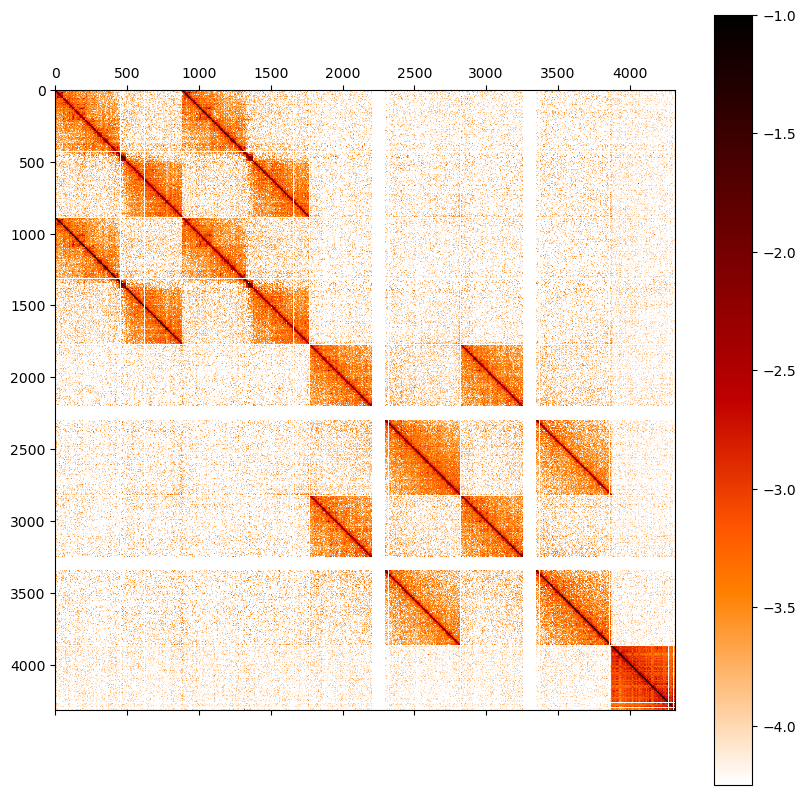

In [5]:
c_50kb.matrix()
mat = c_50kb.matrix(balance=True, sparse=True)[0:total_bins, 0:total_bins]
arr = mat.toarray()#fill in lower triangle

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(arr), cmap='gist_heat_r',vmin = -4.25, vmax = -1)

fig.colorbar(im)

### Trans contacts / Cis contacts  (order parameter for pairing)

In [6]:
# Way 1: using all of chromosomes 2 mat and pat

trans_contacts = np.sum(arr[0:884,884:1768])
cis_contacts = np.sum(arr[0:884,0:884])
print('trans_contacts = ',trans_contacts)
print('cis_contacts = ',cis_contacts)
print('trans_contacts / cis_contacts = ',trans_contacts/cis_contacts)

trans_contacts =  nan
cis_contacts =  nan
trans_contacts / cis_contacts =  nan


In [7]:
# Way 2: Using a portion of chromosomes 2 mat and pat about the same size as my simulations.

# 2500*0.5 kb = 1250 kb region in simulation
# 50 kb per bin in the above map
#1250/50=25 bins needed for the below calculation

trans_contacts = np.sum(arr[0:25,884:909])
cis_contacts = np.sum(arr[0:25,0:25])
print('trans_contacts = ',trans_contacts)
print('cis_contacts = ',cis_contacts)
print('trans_contacts / cis_contacts = ',trans_contacts/cis_contacts)

trans_contacts =  nan
cis_contacts =  nan
trans_contacts / cis_contacts =  nan


### Trans chr2 Whole Chromosome 50kb PnM Hi-C Map

/var/folders/yg/xmt_zsl154zd8l51xlg5s_s40000gn/T/ipykernel_4753/844120044.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(arr), cmap='gist_heat_r')


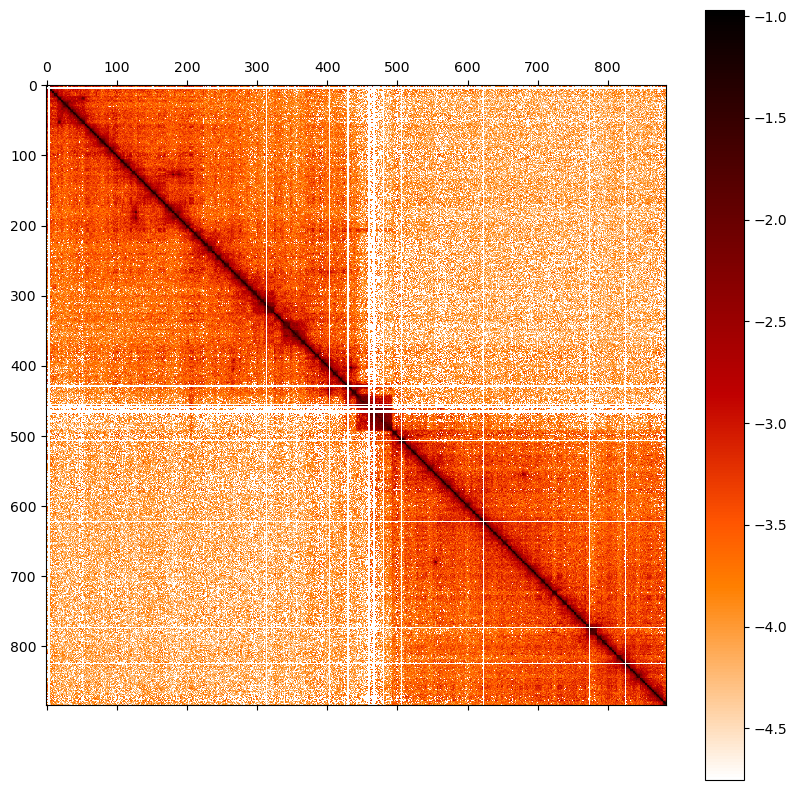

In [8]:
c_50kb.matrix()
mat = c_50kb.matrix(balance=True, sparse=True)[884:1768, 0:884]
arr = mat.toarray()#fill in lower triangle

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(arr), cmap='gist_heat_r')

fig.colorbar(im)
fig.savefig('/Users/douglas/Documents/Features_Transfer/figures/chr2 50kb trans Hi-C diagonal.pdf')

### Chr2 Trans 50kb PnM Hi-C Diagonal

In [15]:
# Explore the chr2 50kb trans Hi-C diagonal.

chr2_bin_max_50_kb = c_50kb.extent(df_50_kb['name'].iloc[1])[-1] # the last bin of both chr2 maternal and chr2 paternal
print('chr2 bins',chr2_bin_max_50_kb)

kb_scale = 500 #the number of kilo base pairs to view along the trans diagonal.
d_0 = round(kb_scale/50) #bins along diagonal of Hi-C map close-up.

@widgets.interact #Refreshes d_window_min and kb_scale with sliders

def close_HiC(d_window_min = (0,chr2_bin_max_50_kb-d_0),normalize=True):
    #Pat=439 varies by row, Mat=057 varies by column.
    arr2 = c_50kb.matrix(balance=normalize)[chr2_bin_max_50_kb+d_window_min:chr2_bin_max_50_kb+d_0+d_window_min,d_window_min:d_0+d_window_min]
    mat2 = c_50kb.matrix(balance=normalize, sparse=True)[chr2_bin_max_50_kb+d_window_min:chr2_bin_max_50_kb+d_0+d_window_min,d_window_min:d_0+d_window_min]
    arr2 = mat2.toarray()#fill in lower triangle
    fig2 = plt.figure(figsize=(10, 10))
    ax2 = fig2.add_subplot(111)
    im2 = ax2.matshow(np.log10(arr2), cmap='gist_heat_r',vmin=-3,vmax=-1)
    fig2.colorbar(im2)
    fig2.savefig('/Users/douglas/Documents/Features_Transfer/figures/chr2 trans 50kb Hi-C diagonal close.pdf')

chr2 bins 884


interactive(children=(IntSlider(value=437, description='d_window_min', max=874), Checkbox(value=True, descript…

### 50kb res tight = loose

In [ ]:
# At what genomic distance do tight and loose pairing have the same contact frequency?

loose_matrix = c_50kb.matrix(balance=True)[651:655,884+651:884+655] # loosely paired region of a trans map
tight_matrix = c_50kb.matrix(balance=True)[656:671,884+656:884+671] # tightly paired region of a trans map
print('p_loose =',np.average(loose_matrix))
print('')
for d in range(5):
    avg = (np.average(np.diagonal(tight_matrix, offset=d))+np.average(np.diagonal(tight_matrix, offset=-d)))/2
    #print('p_tight','d=',d ,'units = 50kb' , avg)
    print('from',(d-1)*50,'kb to',(d+1)*50,'kb, the average is ',avg)
print('')
print('At genomic distance d within [50kb,100], tight pairing has the same average contact probability as loose pairing.')

# I use this for calibration.
# A 200kb loose domain has contact frequency equal to that of 
# a tightly paired region 50kb away from the diagonal.

# If 500 beads in my simulation corresponds to 200kb, then
# Tight = loose at 50kb(1bead/0.5kb) = 100 beads

# 1kb PnM

### Load 1kb PnM Hi-C Map

In [ ]:
#1000 selects 1kb resolution.
filepath_1kb = '/Users/douglas/Documents/Features_Transfer/store_Hi-C/JJ10_11_17_18.wo3kbCisTransHom.1000.cool'
c_1kb = cooler.Cooler(filepath_1kb)

### Tables About 1kb PnM Hi-C Map

In [ ]:
# 057 = maternal
# 439 = paternal
# length units are base pairs
df_1_kb = c_1kb.chroms()[:] #df_1_kb stands for (pandas) data frame
total_length_bp = df_1_kb['length'].sum()#Total number of base pairs in the PnM Hi-C map
total_bins = c_1kb.extent(df_1_kb['name'].iloc[-1])[-1] #Total number of bins in the PnM Hi-C map.
print('Total base pairs in Hi-C map: ',total_length_bp)
print('Total bins in Hi-C map:       ',total_bins)
print('Total base pairs/total bins:  ', total_length_bp/total_bins)
print('')
print('057 = maternal; 439 = paternal')
print('')
print(df_1_kb)

print('')
for name in c_1kb.chromnames:
    print(name,'   ', c_1kb.extent(name))
    
#name    (start_index, stop_index)

### Trans contacts / Cis contacts  (order parameter for pairing)

In [ ]:
c_1kb.matrix()
arr1 = c_1kb.matrix(balance=False)[0:88318, 0:88318]
mat1 = c_1kb.matrix(balance=False, sparse=True)[0:88318, 0:88318]
arr1 = mat1.toarray()#fill in lower triangle

# Way 3: Using a portion of chromosomes 2 mat and pat about the same size as my simulations.

# 2500*0.5 kb = 1250 kb region in simulation
# 1 kb per bin in the above map
# 1250 bins needed for the below calculation

trans_contacts = np.sum(arr1[0:1250,23012:1250+23012])
cis_contacts = np.sum(arr1[0:1250,0:1250])
print('trans_contacts = ',trans_contacts)
print('cis_contacts = ',cis_contacts)
print('trans_contacts / cis_contacts = ',trans_contacts/cis_contacts)
print('This value is off because near the diagonal is full of zeros.')

### Chr2 Trans 1kb PnM Hi-C Diagonal

In [ ]:
# Explore the chr2 1kb trans Hi-C diagonal.

chr2_bin_max_1kb = c_1kb.extent(df_1_kb['name'].iloc[1])[-1] # the last bin of both chr2 maternal and chr2 paternal
print('chr2 bins',chr2_bin_max_1kb)

kb_scale = 400 #the number of kilo base pairs to view along the trans diagonal.
d_0 = round(kb_scale/1) #bins along diagonal of Hi-C map close-up.

@widgets.interact #Refreshes d_window_min and kb_scale with sliders

def close_HiC(d_window_min = (0,chr2_bin_max_1kb-d_0),normalize=False):
    #Pat=439 varies by row, Mat=057 varies by column.
    arr2 = c_1kb.matrix(balance=normalize)[chr2_bin_max_1kb+d_window_min:chr2_bin_max_1kb+d_0+d_window_min,d_window_min:d_0+d_window_min]
    mat2 = c_1kb.matrix(balance=normalize, sparse=True)[chr2_bin_max_1kb+d_window_min:chr2_bin_max_1kb+d_0+d_window_min,d_window_min:d_0+d_window_min]
    arr2 = mat2.toarray()#fill in lower triangle
    fig2 = plt.figure(figsize=(10, 10))
    ax2 = fig2.add_subplot(111)
    im2 = ax2.matshow(np.log10(arr2), cma='gist_heat_r')
    fig2.colorbar(im2)
    fig2.savefig('/Users/douglas/Documents/Features_Transfer/figures/chr2 trans 1kb Hi-C diagonal close.pdf')

### 1kb res tight = loose

In [ ]:
# At what genomic distance do tight and loose pairing have the same contact frequency?

loose_matrix2 = c_1kb.matrix(balance=True)[32510:32720,32510+44159:32720+44159] # loosely paired region of a trans map
#tight_matrix2 = c_1kb.matrix(balance=True)[32730:33940,32730+44159:33940+44159] # tightly paired region of a trans map
total = 0.0
counter = 0
for i in range(210):
    for j in range(210):
        new_entry = loose_matrix2[i,j]
        if math.isnan(new_entry) == False: # There are many empty (NaN) entries in the matrix. We can't include them in an average.
            total += new_entry
            counter += 1
print('total =',total,'; counter =',counter)
print('p_loose =',total/counter)    
print('')

## Probability vs genomic distance for chromosome 2 (in kb) for calibration purposes

In [ ]:
# Checking that the matrix balancing behaves as expected
M = c_1kb.matrix(balance=True)
from numpy import nansum
for i in range(20):
    print(nansum(M[i,:])) # should be 0.0 if all nan or approximately 1.0 if not all nan

### Cis

In [ ]:
#Calculate average probability vs genomic distance in maternal chromosome 2

print('loading matrix')
numpy_chr2_cis_1kb = c_1kb.matrix(balance=True)[0:44159,0:44159]
N = 44159

print('taking average')
d_max = 20000 # The max genomic distance at which to plot P vs d.
average = np.zeros(d_max)
for d in range(d_max):
    sum_d = 0.0
    counter = 0 # counts how many numbers are being averaged
    for i in range(d,N):
        new_entry = numpy_chr2_cis_1kb[i,i-d] # The matrix entry to be possibly included in the average.
        if math.isnan(new_entry) == False: # There are many empty (NaN) entries in the matrix. We can't include them in an average.
            sum_d += new_entry
            counter += 1
    avg = sum_d/counter
    average[d] = avg

plt.plot(average)
plt.yscale('log')
plt.title('Experimental average P vs d at 1kb resolution')
np.savetxt("/Users/douglas/Documents/Features_Transfer/figures/chr2_1kbRes_cis_P_vs_d.txt",average)

### Trans

In [ ]:
#Calculate average probability vs trans genomic distance in chromosome 2

print('loading matrix')
numpy_chr2_trans_1kb = c_1kb.matrix(balance=True)[0:44159,44159:2*44159]
N = 44159

print('taking average')
d_max = 20000 # The max trans genomic distance at which to plot P vs d.
average = np.zeros(d_max)
for d in range(d_max):
    sum_d = 0.0
    counter = 0 # counts how many numbers are being averaged
    for i in range(d,N):
        new_entry = numpy_chr2_trans_1kb[i,i-d] # The matrix entry to be possibly included in the average.
        if math.isnan(new_entry) == False: # There are many empty (NaN) entries in the matrix. We can't include them in an average.
            sum_d += new_entry
            counter += 1
    avg = sum_d/counter
    average[d] = avg

plt.plot(average)
plt.yscale('log')
plt.title('Experimental average P vs d at 1kb resolution')
np.savetxt("/Users/douglas/Documents/Features_Transfer/figures/chr2_1kbRes_trans_P_vs_d.txt",average)

<font color='white'>
# Filler Text to Prevent Annoying Scrolling Behavior When Above Cell Refreshes.<br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
a <br>
</font>